In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import gc

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## ベースライン作成

### データセットの作成

In [3]:
x_train, y_train, id_train = df[['Pclass', 'Fare']], df[['Survived']], df[['PassengerId']]

### ベースライン検証用データの作成

In [4]:
# ベースライン検証用データ(x_va, y_va)の作成
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=123)

### クロスバリデーション(5-fold)

In [5]:
# x_tr.loc[] 　ERROR:'Passing list-likes to .loc or [] with any missing labels is no longer supported
# -> 存在しないキーに対して.locで参照しようとしているためエラーが発生。x_trはベースライン検証データを分割した際に欠損ができている。
# indexを更新したら解決するか
x_tr = x_tr.reset_index(drop=True)
y_tr = y_tr.reset_index(drop=True)

In [6]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc', 
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

metrics = []
imp = pd.DataFrame()


n_splits = 5
# x_tr, y_trのデータセットの分割の組み合わせをn_splits種類作成、それぞれのindexをリストで所持
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_tr, y_tr))

# クロスバリデーション
for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    # 学習データ(x_tr1,y_tr1)と検証データ(x_va1,y_va1)の分割
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1] # 各組合わせcv[tr],cv[va]のidxを格納
    x_tr1, y_tr1 = x_tr.loc[idx_tr], y_tr.loc[idx_tr] # trindex -> 学習用データフレイム作成
    x_va1, y_va1 = x_tr.loc[idx_va], y_tr.loc[idx_va] # vaindex -> 検証用データフレイム作成
    print(x_tr1.shape, y_tr1.shape) # 学習データ
    print(x_va1.shape, y_va1.shape) # 検証データ
    print('y_tr:{:.3f}, y_tr1:{:.3f}, y_va1:{:.3f}'.format(y_tr['Survived'].mean(),
                                               y_tr1['Survived'].mean(),
                                               y_va1['Survived'].mean(),
                                               ))
    
    # モデル学習
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr1, y_tr1,
              eval_set = [(x_tr1, y_tr1), (x_va1, y_va1)],
              callbacks=[lgb.early_stopping(stopping_rounds=100,
                                            verbose=10)
                         ])
    
    # 精度評価
    y_va1_pred = model.predict(x_va1) 
    y_va_pred = model.predict(x_va)    
    metric_va1 = accuracy_score(y_va1, y_va1_pred) # 検証用データ
    metric_va = accuracy_score(y_va, y_va_pred) # ベースライン検証用データ
    print(f'[検証用データ]acc:{metric_va1:.4f}')
    print(f'[ベースライン検証用データ]acc:{metric_va:.4f}')
    
    metrics.append([nfold, metric_va1, metric_va])
    _imp = pd.DataFrame({'col': x_tr.columns,
                         'imp':model.feature_importances_,
                         'nfold': nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

-------------------- 0 --------------------
(569, 2) (569, 1)
(143, 2) (143, 1)
y_tr:0.383, y_tr1:0.383, y_va1:0.385
[1]	training's auc: 0.779372	valid_1's auc: 0.682645
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.782626	valid_1's auc: 0.704649
[3]	training's auc: 0.781176	valid_1's auc: 0.682541
[4]	training's auc: 0.784391	valid_1's auc: 0.703822
[5]	training's auc: 0.784874	valid_1's auc: 0.701136
[6]	training's auc: 0.784704	valid_1's auc: 0.690806
[7]	training's auc: 0.785992	valid_1's auc: 0.688946
[8]	training's auc: 0.790487	valid_1's auc: 0.696798
[9]	training's auc: 0.791859	valid_1's auc: 0.69938
[10]	training's auc: 0.790651	valid_1's auc: 0.695868
[11]	training's auc: 0.791742	valid_1's auc: 0.70062
[12]	training's auc: 0.794539	valid_1's auc: 0.687913
[13]	training's auc: 0.795297	valid_1's auc: 0.700826
[14]	training's auc: 0.796179	valid_1's auc: 0.696281
[15]	training's auc: 0.797923	valid_1's auc: 0.70155
[16]	training's auc: 0.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[132]	training's auc: 0.853636	valid_1's auc: 0.734607
[133]	training's auc: 0.85374	valid_1's auc: 0.734401
[134]	training's auc: 0.854002	valid_1's auc: 0.733781
[135]	training's auc: 0.85408	valid_1's auc: 0.734194
[136]	training's auc: 0.854302	valid_1's auc: 0.734401
[137]	training's auc: 0.854459	valid_1's auc: 0.734814
[138]	training's auc: 0.854433	valid_1's auc: 0.733988
[139]	training's auc: 0.854734	valid_1's auc: 0.734814
[140]	training's auc: 0.854786	valid_1's auc: 0.734401
[141]	training's auc: 0.85489	valid_1's auc: 0.734814
[142]	training's auc: 0.85472	valid_1's auc: 0.73564
[143]	training's auc: 0.854825	valid_1's auc: 0.734194
[144]	training's auc: 0.855113	valid_1's auc: 0.73626
[145]	training's auc: 0.855008	valid_1's auc: 0.735434
[146]	training's auc: 0.855165	valid_1's auc: 0.733368
[147]	training's auc: 0.855361	valid_1's auc: 0.734401
[148]	training's auc: 0.855269	valid_1's auc: 0.734401
[149]	training's auc: 0.855557	valid_1's auc: 0.73564
[150]	training's

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (


[98]	training's auc: 0.827681	valid_1's auc: 0.73688
[99]	training's auc: 0.828282	valid_1's auc: 0.733988
[100]	training's auc: 0.827929	valid_1's auc: 0.732955
[101]	training's auc: 0.82857	valid_1's auc: 0.735227
[102]	training's auc: 0.82904	valid_1's auc: 0.735434
[103]	training's auc: 0.82938	valid_1's auc: 0.734607
[104]	training's auc: 0.829798	valid_1's auc: 0.73688
[105]	training's auc: 0.829654	valid_1's auc: 0.737707
[106]	training's auc: 0.829968	valid_1's auc: 0.737293
[107]	training's auc: 0.829916	valid_1's auc: 0.735434
[108]	training's auc: 0.830726	valid_1's auc: 0.738326
[109]	training's auc: 0.831079	valid_1's auc: 0.738326
[110]	training's auc: 0.831471	valid_1's auc: 0.739773
[111]	training's auc: 0.831732	valid_1's auc: 0.73936
[112]	training's auc: 0.832164	valid_1's auc: 0.738326
[113]	training's auc: 0.832138	valid_1's auc: 0.739566
Early stopping, best iteration is:
[13]	training's auc: 0.780555	valid_1's auc: 0.760331
[検証用データ]acc:0.7063
[ベースライン検証用データ]acc:0

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[68]	training's auc: 0.836521	valid_1's auc: 0.70907
[69]	training's auc: 0.836872	valid_1's auc: 0.708018
[70]	training's auc: 0.837132	valid_1's auc: 0.705492
[71]	training's auc: 0.837613	valid_1's auc: 0.707386
[72]	training's auc: 0.838225	valid_1's auc: 0.707597
[73]	training's auc: 0.839018	valid_1's auc: 0.711595
[74]	training's auc: 0.838862	valid_1's auc: 0.711595
[75]	training's auc: 0.839708	valid_1's auc: 0.712858
[76]	training's auc: 0.839344	valid_1's auc: 0.712016
[77]	training's auc: 0.839864	valid_1's auc: 0.711174
[78]	training's auc: 0.840163	valid_1's auc: 0.714962
[79]	training's auc: 0.84054	valid_1's auc: 0.713699
[80]	training's auc: 0.841308	valid_1's auc: 0.713068
[81]	training's auc: 0.841594	valid_1's auc: 0.716225
[82]	training's auc: 0.8411	valid_1's auc: 0.716856
[83]	training's auc: 0.841568	valid_1's auc: 0.714962
[84]	training's auc: 0.841503	valid_1's auc: 0.717066
[85]	training's auc: 0.841997	valid_1's auc: 0.716014
[86]	training's auc: 0.842804	va

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[106]	training's auc: 0.837371	valid_1's auc: 0.77628
[107]	training's auc: 0.837397	valid_1's auc: 0.774817
[108]	training's auc: 0.837306	valid_1's auc: 0.776071
[109]	training's auc: 0.837254	valid_1's auc: 0.774608
[110]	training's auc: 0.837553	valid_1's auc: 0.773772
[111]	training's auc: 0.837905	valid_1's auc: 0.774399
[112]	training's auc: 0.838062	valid_1's auc: 0.774817
[113]	training's auc: 0.838427	valid_1's auc: 0.775444
[114]	training's auc: 0.838309	valid_1's auc: 0.775026
[115]	training's auc: 0.839248	valid_1's auc: 0.775653
[116]	training's auc: 0.838909	valid_1's auc: 0.775026
[117]	training's auc: 0.839691	valid_1's auc: 0.776489
[118]	training's auc: 0.839612	valid_1's auc: 0.775862
[119]	training's auc: 0.839417	valid_1's auc: 0.773981
[120]	training's auc: 0.840264	valid_1's auc: 0.775235
[121]	training's auc: 0.84059	valid_1's auc: 0.774817
[122]	training's auc: 0.840603	valid_1's auc: 0.776071
[123]	training's auc: 0.840955	valid_1's auc: 0.77628
[124]	trainin

### 精度評価

In [7]:
print('-'*20, 'result', '-'*20)
metrics = np.array(metrics)
print(metrics)

print('[cv]検証用データ: {:.3f}+-{:.3f}, ベースライン検証用データ: {:.3f}+-{:.3f}'.format(
    metrics[:, 1].mean(), metrics[:, 1].std(),
    metrics[:, 2].mean(), metrics[:, 2].std(),
))

imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp.columns = ['imp', 'imp_std']
imp = imp.reset_index(drop=False)

print('Done')

-------------------- result --------------------
[[0.         0.69230769 0.69832402]
 [1.         0.70629371 0.70949721]
 [2.         0.73239437 0.70391061]
 [3.         0.71126761 0.72067039]
 [4.         0.71126761 0.70949721]]
[cv]検証用データ: 0.711+-0.013, ベースライン検証用データ: 0.708+-0.007
Done


In [ ]:
# 説明変数の重要度算出
imp.sort_values('imp', ascending=False, ignore_index=True)

In [28]:
# 誤差分布
print('検証用データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred,  normalize='all')) # 全データを分母とした割合
print('ベースライン検証用データ')
print(confusion_matrix(y_va, y_va_pred))
print(confusion_matrix(y_va, y_va_pred,  normalize='all'))

検証用データ
[[75 12]
 [30 25]]
[[0.52816901 0.08450704]
 [0.21126761 0.17605634]]
ベースライン検証用データ
[[87 23]
 [29 40]]
[[0.48603352 0.12849162]
 [0.16201117 0.22346369]]


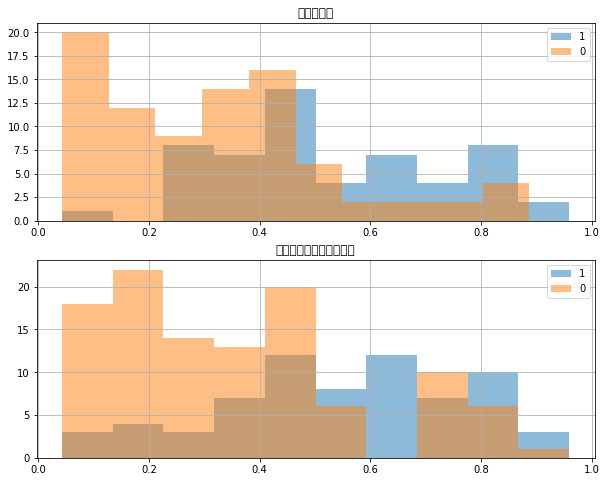

In [39]:
# 予測値の分布比較
y_va1_pred_prod = model.predict_proba(x_va1)[:, 1]
y_va_pred_prod = model.predict_proba(x_va)[:, 1]

fig = plt.figure(figsize=(10, 8))

fig.add_subplot(2, 1, 1)
plt.title('検証データ')
plt.hist(y_va1_pred_prod[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prod[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2, 1, 2)
plt.title('ベースライン検証データ')
plt.hist(y_va_pred_prod[np.array(y_va).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va_pred_prod[np.array(y_va).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

### モデル推論

In [41]:
df_test = pd.read_csv('test.csv')
x_test = df_test[['Pclass', 'Fare']]
id_test = df_test[['PassengerId']]
y_test_pred = model.predict(x_test)
df_submit = pd.DataFrame({
    'PassengerId': id_test['PassengerId'],
    'Survived': y_test_pred
})
df_submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [42]:
df_submit.to_csv('c_submission_baseline.csv', index=None)